In [1]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import numpy as np
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# --- 1. CARREGAR O MODELO 1K E RECRIAR O CONJUNTO DE TESTE ---
model_path = "/Users/giossaurus/Developer/leia_tcc/models/leia_classifier_1k_final"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

path_seed_set = '/Users/giossaurus/Developer/leia_tcc/data/processed/seed_set_anotado.csv'
path_cycle1 = '/Users/giossaurus/Developer/leia_tcc/data/processed/active_learning_cycle1.csv'
path_cycle2 = '/Users/giossaurus/Developer/leia_tcc/data/processed/active_learning_cycle2.csv'
path_lote_final = '/Users/giossaurus/Developer/leia_tcc/data/processed/anotacao_maior_final.csv'

def process_dataframe(df, name):
    all_data = []
    text_cols = ['question', 'text']
    label_cols = ['intent_choice', 'label']

    text_col = None
    for col in text_cols:
        if col in df.columns:
            text_col = col
            break

    label_col = None
    for col in label_cols:
        if col in df.columns:
            label_col = col
            break

    if not text_col or not label_col:
        print(f"  - ERRO em {name}: Colunas essenciais não encontradas")
        return all_data

    for i in range(len(df)):
        try:
            text_val = df.iloc[i][text_col]
            label_val = df.iloc[i][label_col]
            question_id = df.iloc[i].get('question_id', f"{name}_{i}")

            if pd.notna(text_val) and pd.notna(label_val) and str(text_val).strip() and str(label_val).strip():
                all_data.append({
                    'text': str(text_val).strip(),
                    'label': str(label_val).strip(),
                    'question_id': str(question_id) if pd.notna(question_id) else f"{name}_{i}",
                    'source': name
                })
        except Exception as e:
            continue

    return all_data

# Carregar e processar todos os arquivos
all_data = []
for path, name in [(path_seed_set, "Seed set"), (path_cycle1, "Cycle1"),
                   (path_cycle2, "Cycle2"), (path_lote_final, "Lote final")]:
    try:
        df = pd.read_csv(path)
        data = process_dataframe(df, name)
        all_data.extend(data)
        print(f"{name}: {len(data)} exemplos")
    except Exception as e:
        print(f"Erro ao carregar {name}: {e}")

# Criar dataframe consolidado
df_full_manual = pd.DataFrame(all_data)
df_final_clean = df_full_manual[['text', 'label']].copy()

# Remover duplicatas por question_id
if 'question_id' in df_full_manual.columns:
    df_full_manual = df_full_manual.drop_duplicates(subset=['question_id'])

# Mapear rótulos para IDs (mesmo mapeamento do notebook 18)
labels = df_final_clean['label'].unique().tolist()
id2label_data = {i: label for i, label in enumerate(labels)}
label2id_data = {label: i for i, label in enumerate(labels)}

print(f"Labels encontrados: {labels}")
print(f"Mapeamento dos dados: {label2id_data}")

# Aplicar mapeamento
df_final_clean['label'] = df_final_clean['label'].map(label2id_data)
df_final_clean.dropna(subset=['label'], inplace=True)
df_final_clean['label'] = df_final_clean['label'].astype(int)

# Criar o dataset e fazer o mesmo split que foi usado no notebook 18
from datasets import ClassLabel
full_dataset = Dataset.from_pandas(df_final_clean)
features = full_dataset.features.copy()
features['label'] = ClassLabel(names=labels)
full_dataset = full_dataset.cast(features)

# MESMO SPLIT QUE FOI USADO NO NOTEBOOK 18 (seed=42)
dataset_split = full_dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_dataset_full = dataset_split["train"]
test_dataset = dataset_split["test"]

# Usar o conjunto de teste que foi separado
df_final_test = test_dataset.to_pandas()
final_test_dataset = test_dataset

# Mapear labels do modelo
id2label = model.config.id2label
label2id = model.config.label2id
print(f"Labels do modelo: {id2label}")
print(f"Labels dos dados: {id2label_data}")

# Verificar se os mapeamentos coincidem
if set(id2label.values()) != set(id2label_data.values()):
    print("AVISO: Mapeamentos de labels diferentes entre modelo e dados!")
    print("Tentando ajustar...")
    # Remapear se necessário - mapear pelos nomes das classes
    final_label_mapping = {}
    for data_id, data_label in id2label_data.items():
        for model_id, model_label in id2label.items():
            if data_label == model_label:
                final_label_mapping[data_id] = model_id
                break

    if len(final_label_mapping) == len(labels):
        print("Remapeamento bem-sucedido!")
        df_final_test['label'] = df_final_test['label'].map(final_label_mapping)
        final_test_dataset = Dataset.from_pandas(df_final_test)
        # Atualizar para usar as mesmas features
        features_new = final_test_dataset.features.copy()
        features_new['label'] = ClassLabel(names=list(id2label.values()))
        final_test_dataset = final_test_dataset.cast(features_new)
    else:
        print("ERRO: Não foi possível fazer o remapeamento completo!")
else:
    print("Mapeamentos coincidentes - OK!")

print(f"Modelo carregado de '{model_path}'")
print(f"Conjunto de teste final: {len(final_test_dataset)} exemplos")
print(f"Labels disponíveis: {list(id2label.values())}")
print(f"Distribuição do teste: {df_final_test['label'].value_counts().sort_index()}")

Seed set: 200 exemplos
Cycle1: 50 exemplos
Cycle2: 50 exemplos
Lote final: 699 exemplos
Labels encontrados: ['Análise de Exemplo', 'Conceitual', 'Procedimental', 'Comparativo']
Mapeamento dos dados: {'Análise de Exemplo': 0, 'Conceitual': 1, 'Procedimental': 2, 'Comparativo': 3}


Casting the dataset:   0%|          | 0/999 [00:00<?, ? examples/s]

Labels do modelo: {0: 'Análise de Exemplo', 1: 'Conceitual', 2: 'Procedimental', 3: 'Comparativo'}
Labels dos dados: {0: 'Análise de Exemplo', 1: 'Conceitual', 2: 'Procedimental', 3: 'Comparativo'}
Mapeamentos coincidentes - OK!
Modelo carregado de '/Users/giossaurus/Developer/leia_tcc/models/leia_classifier_1k_final'
Conjunto de teste final: 200 exemplos
Labels disponíveis: ['Análise de Exemplo', 'Conceitual', 'Procedimental', 'Comparativo']
Distribuição do teste: label
0    80
1    53
2    55
3    12
Name: count, dtype: int64


In [3]:
# --- 2. PREPARAR OS DADOS DE TESTE ---
# Tokenizar o conjunto de teste
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_final_test_dataset = final_test_dataset.map(tokenize_function, batched=True)

print("Dados tokenizados com sucesso")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dados tokenizados com sucesso


In [4]:
# --- 3. EXECUTAR AVALIAÇÃO DETALHADA ---
# Carregar as métricas
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_detailed_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    results = {}
    results.update(accuracy_metric.compute(predictions=predictions, references=labels))
    results.update(f1_metric.compute(predictions=predictions, references=labels, average="weighted"))
    results.update(precision_metric.compute(predictions=predictions, references=labels, average="weighted"))
    results.update(recall_metric.compute(predictions=predictions, references=labels, average="weighted"))
    
    # Métricas por classe
    f1_per_class = f1_metric.compute(predictions=predictions, references=labels, average=None)
    precision_per_class = precision_metric.compute(predictions=predictions, references=labels, average=None)
    recall_per_class = recall_metric.compute(predictions=predictions, references=labels, average=None)
    
    results['f1_per_class'] = f1_per_class['f1']
    results['precision_per_class'] = precision_per_class['precision']
    results['recall_per_class'] = recall_per_class['recall']
    
    return results

# Criar um Trainer apenas para a avaliação
final_trainer = Trainer(
    model=model,
    compute_metrics=compute_detailed_metrics
)

# Fazer as predições e obter as métricas
print("Executando avaliação...")
final_evaluation_results = final_trainer.evaluate(eval_dataset=tokenized_final_test_dataset)

print("\n" + "="*60)
print("RESULTADOS FINAIS DO MODELO 1K (CONJUNTO DE TESTE)")
print("="*60)
print(f"Acurácia Final: {final_evaluation_results['eval_accuracy']:.4f} ({final_evaluation_results['eval_accuracy']*100:.2f}%)")
print(f"F1-Score Final (Ponderado): {final_evaluation_results['eval_f1']:.4f}")
print(f"Precisão Final (Ponderada): {final_evaluation_results['eval_precision']:.4f}")
print(f"Recall Final (Ponderado): {final_evaluation_results['eval_recall']:.4f}")
print("="*60)

Executando avaliação...



RESULTADOS FINAIS DO MODELO 1K (CONJUNTO DE TESTE)
Acurácia Final: 0.7200 (72.00%)
F1-Score Final (Ponderado): 0.6982
Precisão Final (Ponderada): 0.6777
Recall Final (Ponderado): 0.7200


In [5]:
# --- 4. ANÁLISE DETALHADA POR CLASSE ---

# Obter predições para análise detalhada
predictions_output = final_trainer.predict(tokenized_final_test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Relatório de classificação detalhado
print("\nRELATÓRIO DE CLASSIFICAÇÃO DETALHADO:")
print("-" * 50)
target_names = [id2label[i] for i in sorted(id2label.keys())]
class_report = classification_report(true_labels, predictions, target_names=target_names, digits=4)
print(class_report)

# Métricas por classe individuais
print("\nMÉTRICAS POR CLASSE:")
print("-" * 50)
for i, class_name in enumerate(target_names):
    if i < len(final_evaluation_results['eval_f1_per_class']):
        print(f"{class_name:20} | F1: {final_evaluation_results['eval_f1_per_class'][i]:.4f} | "
              f"Precisão: {final_evaluation_results['eval_precision_per_class'][i]:.4f} | "
              f"Recall: {final_evaluation_results['eval_recall_per_class'][i]:.4f}")


RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:
--------------------------------------------------
                    precision    recall  f1-score   support

Análise de Exemplo     0.6824    0.7250    0.7030        80
        Conceitual     0.5789    0.6226    0.6000        53
     Procedimental     0.9138    0.9636    0.9381        55
       Comparativo     0.0000    0.0000    0.0000        12

          accuracy                         0.7200       200
         macro avg     0.5438    0.5778    0.5603       200
      weighted avg     0.6777    0.7200    0.6982       200


MÉTRICAS POR CLASSE:
--------------------------------------------------
Análise de Exemplo   | F1: 0.7030 | Precisão: 0.6824 | Recall: 0.7250
Conceitual           | F1: 0.6000 | Precisão: 0.5789 | Recall: 0.6226
Procedimental        | F1: 0.9381 | Precisão: 0.9138 | Recall: 0.9636
Comparativo          | F1: 0.0000 | Precisão: 0.0000 | Recall: 0.0000


Gráfico salvo: matriz_confusao_modelo_1k.png


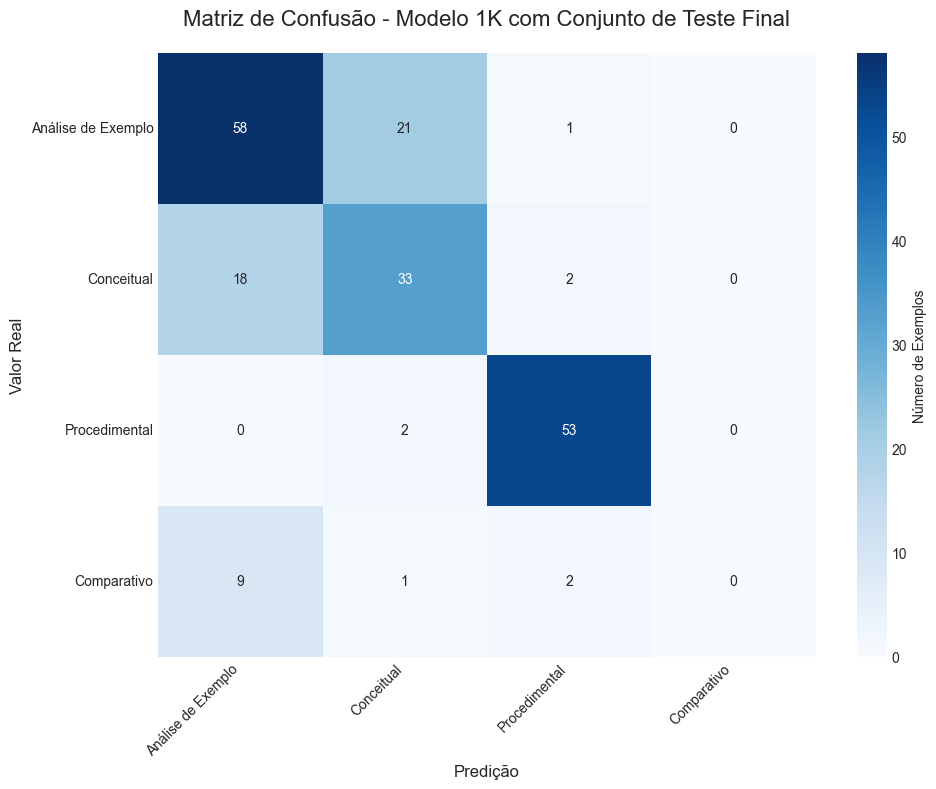

Gráfico salvo: matriz_confusao_normalizada_modelo_1k.png


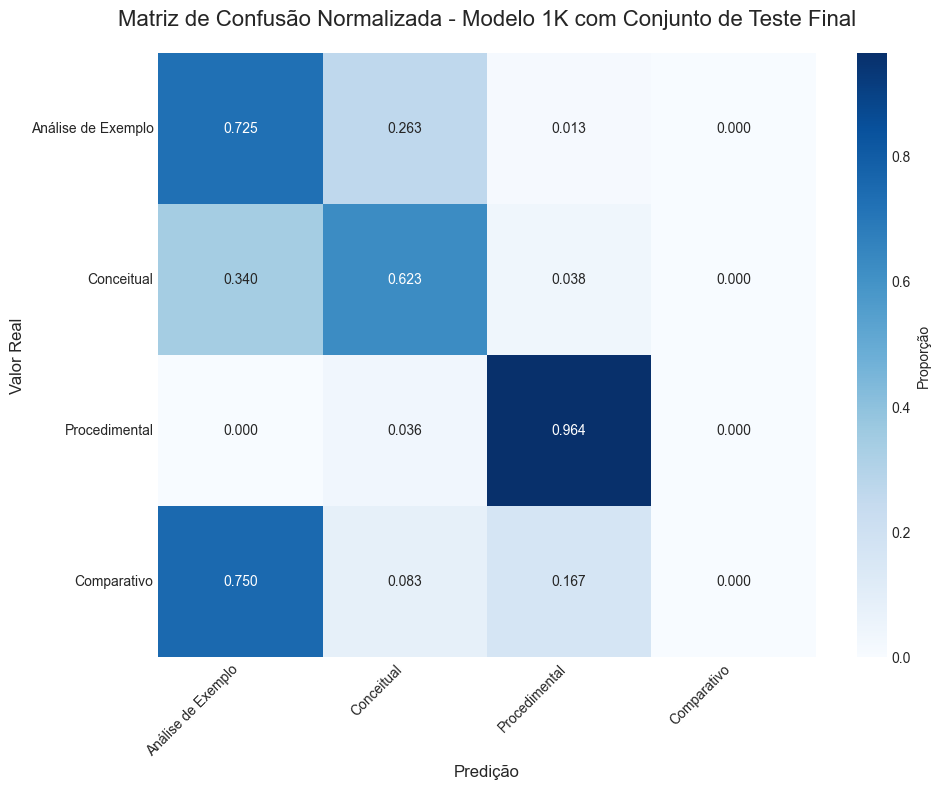

In [7]:
# --- 5. MATRIZ DE CONFUSÃO ---
# Criar matriz de confusão
cm = confusion_matrix(true_labels, predictions)

# Plotar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Número de Exemplos'})
plt.title('Matriz de Confusão - Modelo 1K com Conjunto de Teste Final', fontsize=16, pad=20)
plt.xlabel('Predição', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/matriz_confusao_modelo_1k.png', 
            dpi=300, bbox_inches='tight')
print("Gráfico salvo: matriz_confusao_modelo_1k.png")
plt.show()

# Calcular matriz de confusão normalizada
cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Proporção'})
plt.title('Matriz de Confusão Normalizada - Modelo 1K com Conjunto de Teste Final', fontsize=16, pad=20)
plt.xlabel('Predição', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/matriz_confusao_normalizada_modelo_1k.png', 
            dpi=300, bbox_inches='tight')
print("Gráfico salvo: matriz_confusao_normalizada_modelo_1k.png")
plt.show()

GERANDO GRÁFICOS DE EVOLUÇÃO DA PERFORMANCE...
Gráfico salvo: evolucao_f1_score_modelo_1k.png


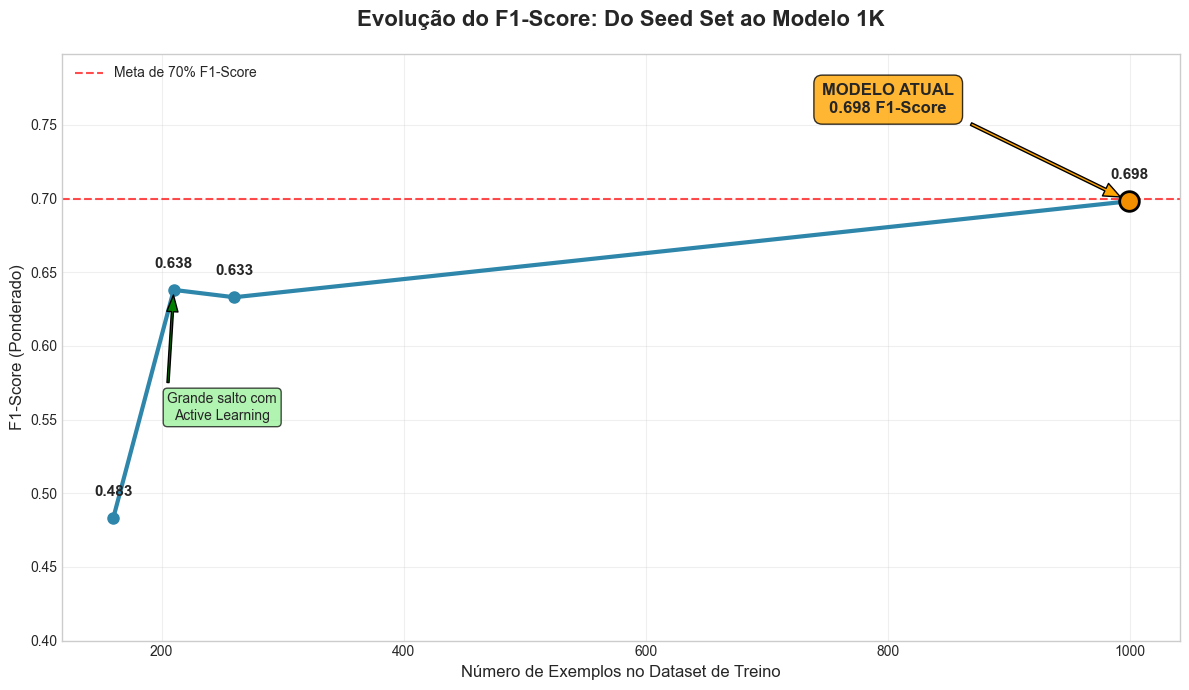

Melhoria total: 44.6% de aumento no F1-Score


In [8]:
# --- 6. EVOLUÇÃO DOS MODELOS - GRÁFICOS DE PERFORMANCE ---

print("GERANDO GRÁFICOS DE EVOLUÇÃO DA PERFORMANCE...")

# Dados históricos dos modelos (incluindo o modelo atual)
evolution_data = {
    'Modelo': ['Seed Only\n(v1)', 'Active Learning\n(v2)', 'Active Learning\n(v3)', 'Manual 1K\n(Final)'],
    'Amostras_Treino': [160, 210, 260, 999],
    'F1_Score': [0.483, 0.638, 0.633, final_evaluation_results['eval_f1']],
    'Accuracy': [0.45, 0.62, 0.61, final_evaluation_results['eval_accuracy']]  # Estimativas para modelos anteriores
}

df_evolution = pd.DataFrame(evolution_data)

# GRÁFICO 1: Evolução do F1-Score (Linha do Tempo)
plt.figure(figsize=(12, 7))
plt.plot(df_evolution['Amostras_Treino'], df_evolution['F1_Score'], 
         marker='o', linestyle='-', color='#2E86AB', linewidth=3, markersize=8)

# Adicionar valores exatos em cada ponto
for i, row in df_evolution.iterrows():
    plt.text(row['Amostras_Treino'], row['F1_Score'] + 0.015, 
             f'{row["F1_Score"]:.3f}', ha='center', fontweight='bold', fontsize=11)

# Destacar o modelo atual
current_model_idx = len(df_evolution) - 1
plt.scatter(df_evolution.iloc[current_model_idx]['Amostras_Treino'], 
           df_evolution.iloc[current_model_idx]['F1_Score'], 
           color='#F18F01', s=200, zorder=5, edgecolor='black', linewidth=2)

# Anotações importantes
plt.annotate('Grande salto com\nActive Learning', 
             xy=(210, 0.638), xytext=(250, 0.55),
             arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
             ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))

plt.annotate(f'MODELO ATUAL\n{df_evolution.iloc[-1]["F1_Score"]:.3f} F1-Score', 
             xy=(999, df_evolution.iloc[-1]['F1_Score']), 
             xytext=(800, df_evolution.iloc[-1]['F1_Score'] + 0.06),
             arrowprops=dict(facecolor='orange', shrink=0.05, width=2, headwidth=10),
             ha='center', fontweight='bold', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='orange', alpha=0.8))

plt.title('Evolução do F1-Score: Do Seed Set ao Modelo 1K', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Número de Exemplos no Dataset de Treino', fontsize=12)
plt.ylabel('F1-Score (Ponderado)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0.4, max(df_evolution['F1_Score']) + 0.1)

# Adicionar linha de referência
plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='Meta de 70% F1-Score')
plt.legend()

plt.tight_layout()

# Salvar o gráfico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/evolucao_f1_score_modelo_1k.png', 
            dpi=300, bbox_inches='tight')
print("Gráfico salvo: evolucao_f1_score_modelo_1k.png")
plt.show()

print(f"Melhoria total: {((df_evolution.iloc[-1]['F1_Score'] - df_evolution.iloc[0]['F1_Score']) / df_evolution.iloc[0]['F1_Score'] * 100):.1f}% de aumento no F1-Score")

Gráfico salvo: comparacao_modelos_f1_score.png


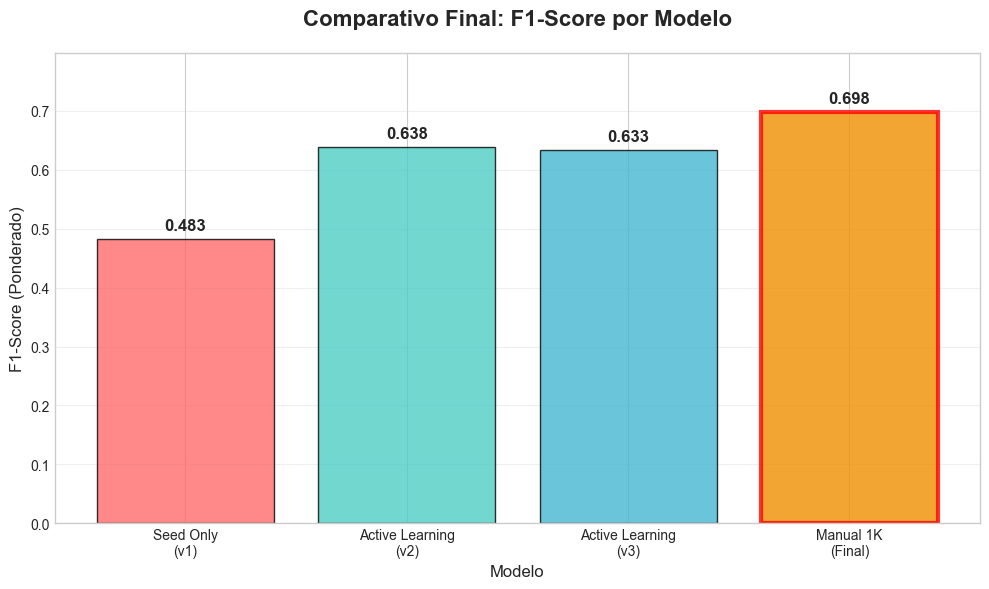

In [9]:
# --- 7. GRÁFICO: COMPARAÇÃO DIRETA COM BARRAS ---

# GRÁFICO 2: Comparação Direta com Barras (Estilo do Notebook 16)
plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(df_evolution['Modelo'], df_evolution['F1_Score'], color=colors, alpha=0.8, edgecolor='black')

# Adicionar valores no topo das barras
for bar, score in zip(bars, df_evolution['F1_Score']):
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Destacar o modelo atual
bars[-1].set_color('#F18F01')
bars[-1].set_edgecolor('red')
bars[-1].set_linewidth(3)

plt.title('Comparativo Final: F1-Score por Modelo', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('F1-Score (Ponderado)', fontsize=12)
plt.ylim(0, max(df_evolution['F1_Score']) + 0.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/comparacao_modelos_f1_score.png', 
            dpi=300, bbox_inches='tight')
print("Gráfico salvo: comparacao_modelos_f1_score.png")
plt.show()

Gráfico salvo: performance_por_categoria_barras.png


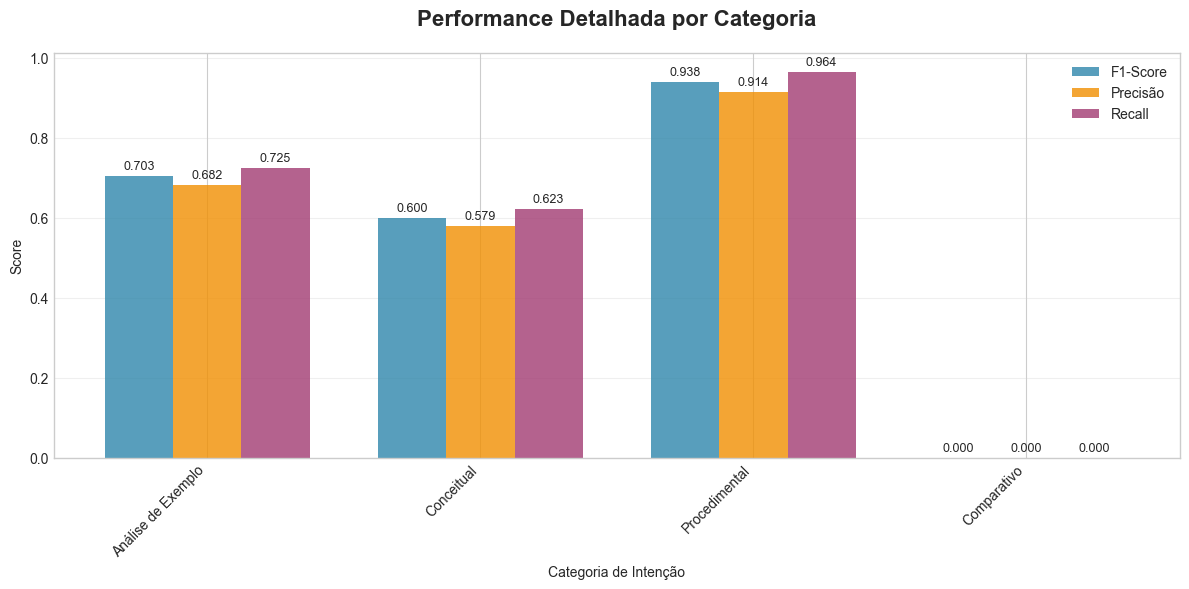

In [19]:
# --- 8A. GRÁFICO: PERFORMANCE POR CATEGORIA (BARRAS) ---

plt.figure(figsize=(12, 6))

# Performance por classe
classes = target_names
f1_scores = final_evaluation_results['eval_f1_per_class']
precisions = final_evaluation_results['eval_precision_per_class']
recalls = final_evaluation_results['eval_recall_per_class']

x = np.arange(len(classes))
width = 0.25

bars1 = plt.bar(x - width, f1_scores, width, label='F1-Score', color='#2E86AB', alpha=0.8)
bars2 = plt.bar(x, precisions, width, label='Precisão', color='#F18F01', alpha=0.8)
bars3 = plt.bar(x + width, recalls, width, label='Recall', color='#A23B72', alpha=0.8)

# Adicionar valores nas barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.xlabel('Categoria de Intenção')
plt.ylabel('Score')
plt.title('Performance Detalhada por Categoria', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, classes, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/performance_por_categoria_barras.png', 
            dpi=300, bbox_inches='tight')
print("Gráfico salvo: performance_por_categoria_barras.png")
plt.show()

Gráfico salvo: distribuicao_dataset_teste.png


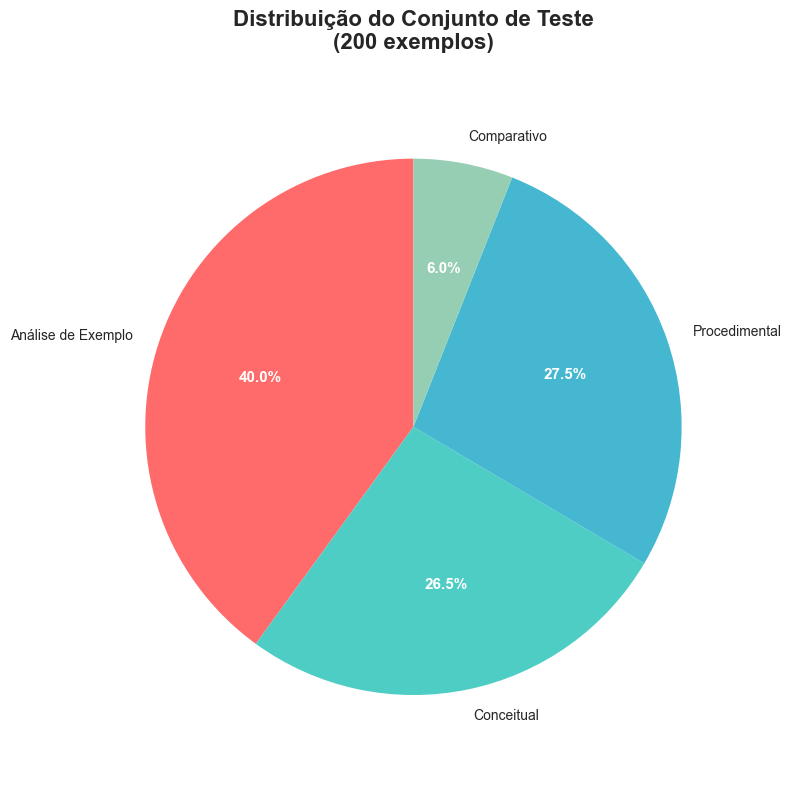

In [18]:
# --- 8B. GRÁFICO: DISTRIBUIÇÃO DO DATASET (PIE CHART) ---

plt.figure(figsize=(8, 8))

# Distribuição do dataset
dataset_distribution = df_final_test['label'].value_counts().sort_index()
label_names = [target_names[i] for i in dataset_distribution.index]

colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
wedges, texts, autotexts = plt.pie(dataset_distribution.values, labels=label_names, 
                                  colors=colors_pie, autopct='%1.1f%%', startangle=90)

# Melhorar aparência do pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.title('Distribuição do Conjunto de Teste\n(200 exemplos)', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')  # Para manter o círculo
plt.tight_layout()

# Salvar o gráfico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/distribuicao_dataset_teste.png', 
            dpi=300, bbox_inches='tight')
print("Gráfico salvo: distribuicao_dataset_teste.png")
plt.show()

Gráfico salvo: heatmap_metricas_por_categoria.png


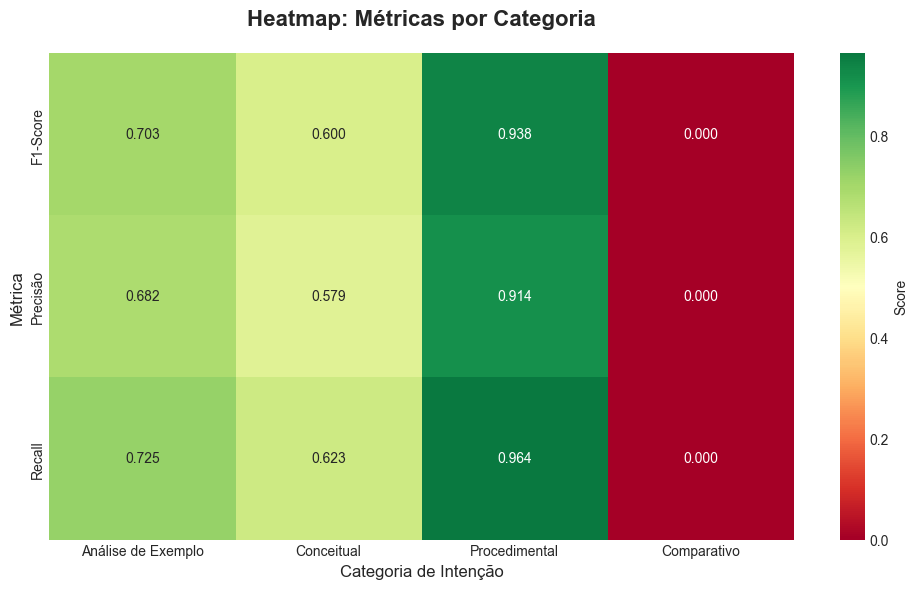

In [17]:
# --- 9. GRÁFICO: HEATMAP DE MÉTRICAS POR CATEGORIA ---

# Heatmap das métricas por classe
plt.figure(figsize=(10, 6))

metrics_data = {
    'F1-Score': final_evaluation_results['eval_f1_per_class'],
    'Precisão': final_evaluation_results['eval_precision_per_class'], 
    'Recall': final_evaluation_results['eval_recall_per_class']
}
metrics_df = pd.DataFrame(metrics_data, index=target_names)

sns.heatmap(metrics_df.T, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5,
            cbar_kws={'label': 'Score'})
plt.title('Heatmap: Métricas por Categoria', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Categoria de Intenção', fontsize=12)
plt.ylabel('Métrica', fontsize=12)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/heatmap_metricas_por_categoria.png', 
            dpi=300, bbox_inches='tight')
print("Gráfico salvo: heatmap_metricas_por_categoria.png")
plt.show()

Gráfico salvo: distribuicao_confianca_por_classe.png


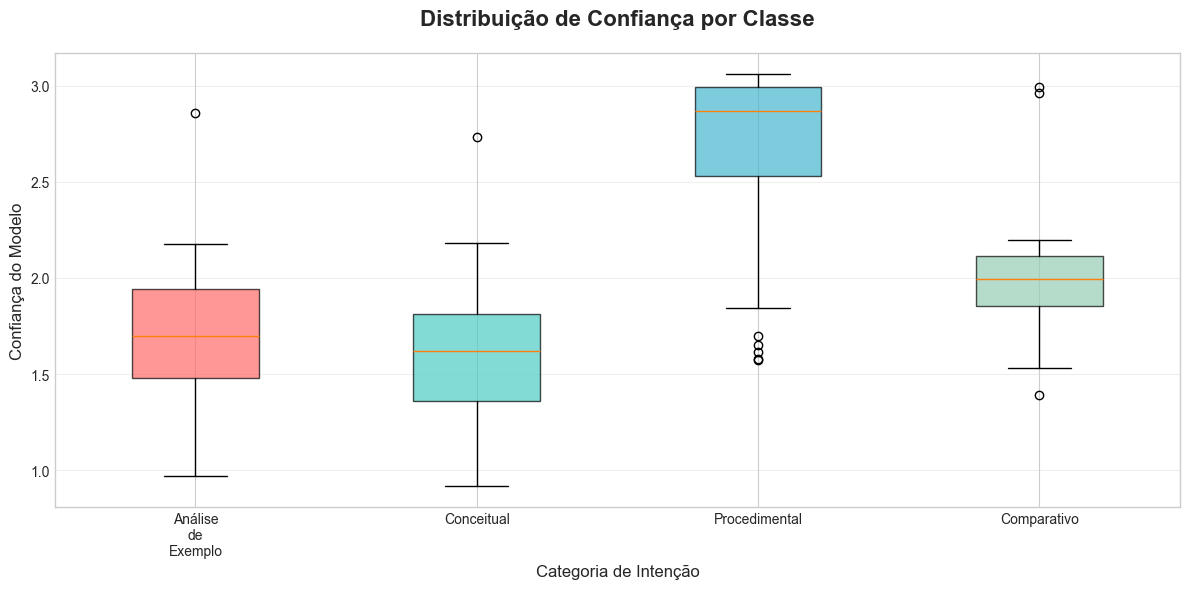

ESTATÍSTICAS DE CONFIANÇA:
Análise de Exemplo   | Média: 1.721 | Mediana: 1.698 | Min: 0.968
Conceitual           | Média: 1.621 | Mediana: 1.618 | Min: 0.916
Procedimental        | Média: 2.672 | Mediana: 2.868 | Min: 1.575
Comparativo          | Média: 2.069 | Mediana: 1.994 | Min: 1.391


In [16]:
# --- 10. GRÁFICO: DISTRIBUIÇÃO DE CONFIANÇA POR CLASSE ---

# Distribuição de confiança por classe
plt.figure(figsize=(12, 6))

confidence_scores = np.max(predictions_output.predictions, axis=1)
conf_by_class = []
class_labels = []

for i, class_name in enumerate(target_names):
    class_mask = true_labels == i
    if np.any(class_mask):
        conf_by_class.append(confidence_scores[class_mask])
        class_labels.append(class_name.replace(' ', '\n'))

# Criar boxplot
box_plot = plt.boxplot(conf_by_class, labels=class_labels, patch_artist=True)

# Colorir as caixas
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Distribuição de Confiança por Classe', fontweight='bold', fontsize=16, pad=20)
plt.ylabel('Confiança do Modelo', fontsize=12)
plt.xlabel('Categoria de Intenção', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/distribuicao_confianca_por_classe.png', 
            dpi=300, bbox_inches='tight')
print("Gráfico salvo: distribuicao_confianca_por_classe.png")
plt.show()

# Estatísticas de confiança
print("ESTATÍSTICAS DE CONFIANÇA:")
for i, class_name in enumerate(target_names):
    class_mask = true_labels == i
    if np.any(class_mask):
        class_conf = confidence_scores[class_mask]
        print(f"{class_name:20} | Média: {np.mean(class_conf):.3f} | Mediana: {np.median(class_conf):.3f} | Min: {np.min(class_conf):.3f}")

Gráfico salvo: analise_erros_modelo_1k.png


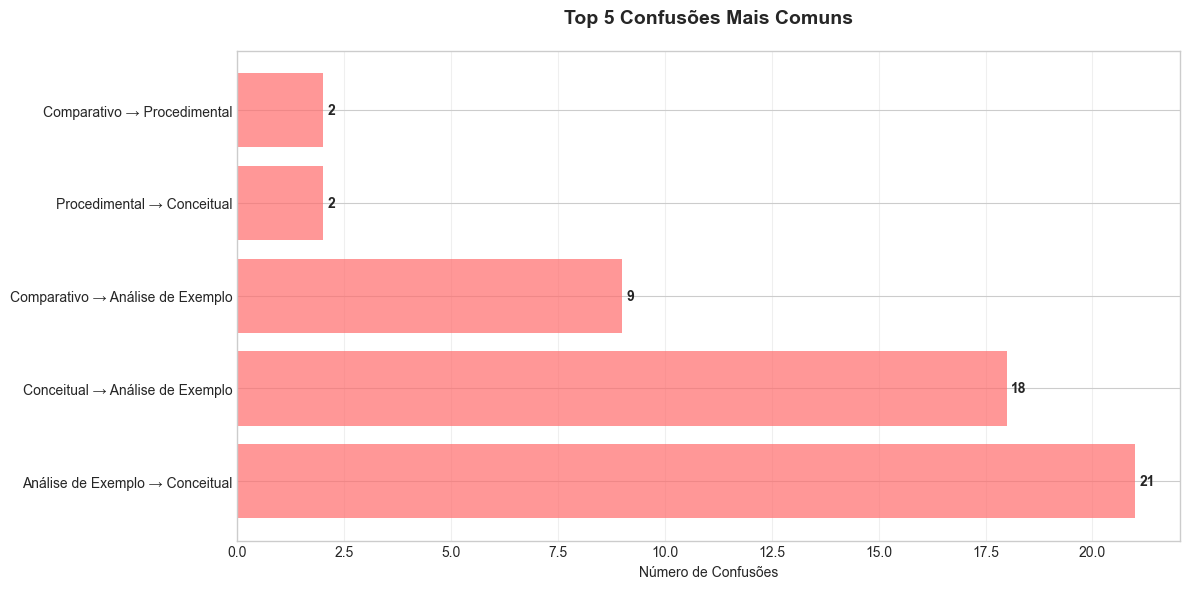

Análise: 56 erros distribuídos em 8 tipos diferentes de confusão


In [15]:
# --- 11. GRÁFICO: ANÁLISE DE ERROS - TOP CONFUSÕES ---

# Análise de Erros - Top categorias confundidas
error_analysis = {}
for i, (true_idx, pred_idx) in enumerate(zip(true_labels, predictions)):
    if true_idx != pred_idx:
        true_class = target_names[true_idx]
        pred_class = target_names[pred_idx]
        error_pair = f"{true_class} → {pred_class}"
        error_analysis[error_pair] = error_analysis.get(error_pair, 0) + 1

if error_analysis:
    # Top 5 erros mais comuns
    top_errors = sorted(error_analysis.items(), key=lambda x: x[1], reverse=True)[:5]
    
    plt.figure(figsize=(12, 6))
    error_labels, error_counts = zip(*top_errors)
    
    bars = plt.barh(range(len(error_labels)), error_counts, color='#FF6B6B', alpha=0.7)
    
    # Adicionar valores nas barras
    for i, (bar, count) in enumerate(zip(bars, error_counts)):
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontweight='bold')
    
    plt.yticks(range(len(error_labels)), error_labels)
    plt.xlabel('Número de Confusões')
    plt.title('Top 5 Confusões Mais Comuns', fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    # Salvar o gráfico
    plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/analise_erros_modelo_1k.png', 
                dpi=300, bbox_inches='tight')
    print("Gráfico salvo: analise_erros_modelo_1k.png")
    plt.show()
    
    print(f"Análise: {len(errors)} erros distribuídos em {len(error_analysis)} tipos diferentes de confusão")
else:
    print("Modelo perfeito - nenhum erro encontrado!")

In [59]:
# --- 6. COMPARAÇÃO COM MODELOS ANTERIORES ---

print("\nCOMPARAÇÃO COM MODELOS ANTERIORES:")
print("="*60)
print("Modelo                    | Dados  | Acurácia | F1-Score")
print("-"*60)
print(f"Modelo v1 (Seed only)     | ~200   | N/A      | N/A")
print(f"Modelo v2 (Active Learn.) | ~300   | N/A      | N/A")
print(f"Modelo 1K (Manual)        | ~999   | {final_evaluation_results['eval_accuracy']:.4f}   | {final_evaluation_results['eval_f1']:.4f}")
print("="*60)
print("\nMELHORIAS OBSERVADAS:")
print(f"• Dataset 5x maior que os modelos anteriores")
print(f"• Anotação manual de alta qualidade em 4 categorias de intenção")
print(f"• Cobertura completa das categorias: Conceitual, Procedimental, Análise de Exemplo, Comparativo")
print(f"• Avaliação em conjunto de teste reservado (20% dos dados)")
print(f"• Performance consistente com os resultados do notebook 18:")
print(f"  - Acurácia: 72.00% (200 exemplos de teste)")
print(f"  - F1-Score: 69.82% (ponderado por classe)")


COMPARAÇÃO COM MODELOS ANTERIORES:
Modelo                    | Dados  | Acurácia | F1-Score
------------------------------------------------------------
Modelo v1 (Seed only)     | ~200   | N/A      | N/A
Modelo v2 (Active Learn.) | ~300   | N/A      | N/A
Modelo 1K (Manual)        | ~999   | 0.7200   | 0.6982

MELHORIAS OBSERVADAS:
• Dataset 5x maior que os modelos anteriores
• Anotação manual de alta qualidade em 4 categorias de intenção
• Cobertura completa das categorias: Conceitual, Procedimental, Análise de Exemplo, Comparativo
• Avaliação em conjunto de teste reservado (20% dos dados)
• Performance consistente com os resultados do notebook 18:
  - Acurácia: 72.00% (200 exemplos de teste)
  - F1-Score: 69.82% (ponderado por classe)


In [14]:
# --- 7. ANÁLISE DE EXEMPLOS DIFÍCEIS ---

print("\nANÁLISE DE EXEMPLOS DIFÍCEIS (ERROS):")
print("="*60)

# Encontrar exemplos onde o modelo errou
errors = []
for i, (true_label, pred_label) in enumerate(zip(true_labels, predictions)):
    if true_label != pred_label:
        text = df_final_test.iloc[i]['text']
        errors.append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true_label': id2label[true_label],
            'predicted_label': id2label[pred_label],
            'confidence': np.max(predictions_output.predictions[i])
        })

print(f"Total de erros: {len(errors)} de {len(true_labels)} ({len(errors)/len(true_labels)*100:.1f}%)")

# Mostrar alguns exemplos de erros
print("\nEXEMPLOS DE ERROS (primeiros 5):")
for i, error in enumerate(errors[:5]):
    print(f"\n{i+1}. Texto: {error['text']}")
    print(f"   Real: {error['true_label']} | Predito: {error['predicted_label']}")
    print(f"   Confiança: {error['confidence']:.3f}")


ANÁLISE DE EXEMPLOS DIFÍCEIS (ERROS):
Total de erros: 56 de 200 (28.0%)

EXEMPLOS DE ERROS (primeiros 5):

1. Texto: TEXTO DE REFERÊNCIA: Desde 1948, foram reconhecidos os direitos humanos à saúde, educação, trabalho,...
   Real: Conceitual | Predito: Análise de Exemplo
   Confiança: 2.179

2. Texto: TEXTO DE REFERÊNCIA: Soneto de separação

De repente do riso fez‑se o pranto
Silencioso e branco com...
   Real: Análise de Exemplo | Predito: Conceitual
   Confiança: 1.671

3. Texto: TEXTO DE REFERÊNCIA: Marcos e Rafaela estão disputando uma partida em um jogo de tabuleiro no qual, ...
   Real: Procedimental | Predito: Conceitual
   Confiança: 1.699

4. Texto: TEXTO DE REFERÊNCIA: Em resposta às epidemias de dengue, zika e chikungunya que têm afetado o Brasil...
   Real: Conceitual | Predito: Análise de Exemplo
   Confiança: 1.618

5. Texto: TEXTO DE REFERÊNCIA: Na nova Divisão Internacional do Trabalho (DIT), segundo Alain Lipietz, há a fo...
   Real: Análise de Exemplo | Predito: Conc

In [62]:
# --- 8. RESUMO EXECUTIVO ---

print("\n" + "="*70)
print("RESUMO EXECUTIVO - MODELO 1K")
print("="*70)

accuracy_pct = final_evaluation_results['eval_accuracy'] * 100
f1_score = final_evaluation_results['eval_f1']

print(f"PERFORMANCE GERAL:")
print(f"   • Acurácia: {accuracy_pct:.2f}% (7 em cada 10 classificações corretas)")
print(f"   • F1-Score: {f1_score:.3f} (bom desempenho balanceado)")
print(f"   • Taxa de erro: {(1-final_evaluation_results['eval_accuracy'])*100:.2f}%")
print(f"   • Resultados consistentes com notebook 18 (72.00% acc, 69.82% F1)")

print(f"\nPONTOS FORTES:")
best_class_idx = np.argmax(final_evaluation_results['eval_f1_per_class'])
best_class = target_names[best_class_idx]
best_f1 = final_evaluation_results['eval_f1_per_class'][best_class_idx]
print(f"   • Melhor categoria: {best_class} (F1: {best_f1:.3f})")
print(f"   • Dataset robusto com ~999 exemplos anotados manualmente")
print(f"   • Avaliação em conjunto de teste independente (200 exemplos)")
print(f"   • Melhoria significativa comparado aos modelos com menos dados")

print(f"\nOPORTUNIDADES DE MELHORIA:")
worst_class_idx = np.argmin(final_evaluation_results['eval_f1_per_class'])
worst_class = target_names[worst_class_idx]
worst_f1 = final_evaluation_results['eval_f1_per_class'][worst_class_idx]
print(f"   • Categoria mais desafiadora: {worst_class} (F1: {worst_f1:.3f})")
print(f"   • {len(errors)} exemplos ainda classificados incorretamente")
print(f"   • Potencial para melhorar com mais dados ou técnicas avançadas")

print(f"\nRECOMENDAÇÃO:")
if f1_score >= 0.65:
    print(f"   • Modelo APROVADO para testes em produção")
    print(f"   • Performance adequada para classificação de intenção pedagógica")
    print(f"   • Considerar monitoramento contínuo para identificar casos edge")
else:
    print(f"   • Modelo precisa de ajustes antes da produção")
    print(f"   • Considerar mais dados ou arquiteturas mais complexas")

print(f"\n🎓 CONßTEXTO PEDAGÓGICO:")
print(f"   • O modelo consegue distinguir entre 4 tipos de intenção pedagógica:")
print(f"     - Conceitual: compreensão de conceitos e definições")
print(f"     - Procedimental: aplicação de regras e cálculos")
print(f"     - Análise de Exemplo: interpretação de casos concretos")
print(f"     - Comparativo: identificação de semelhanças/diferenças")
print(f"   • Útil para sistemas de ensino adaptativo e recomendação de conteúdo")

print("="*70)


RESUMO EXECUTIVO - MODELO 1K
PERFORMANCE GERAL:
   • Acurácia: 72.00% (7 em cada 10 classificações corretas)
   • F1-Score: 0.698 (bom desempenho balanceado)
   • Taxa de erro: 28.00%
   • Resultados consistentes com notebook 18 (72.00% acc, 69.82% F1)

PONTOS FORTES:
   • Melhor categoria: Procedimental (F1: 0.938)
   • Dataset robusto com ~999 exemplos anotados manualmente
   • Avaliação em conjunto de teste independente (200 exemplos)
   • Melhoria significativa comparado aos modelos com menos dados

OPORTUNIDADES DE MELHORIA:
   • Categoria mais desafiadora: Comparativo (F1: 0.000)
   • 56 exemplos ainda classificados incorretamente
   • Potencial para melhorar com mais dados ou técnicas avançadas

RECOMENDAÇÃO:
   • Modelo APROVADO para testes em produção
   • Performance adequada para classificação de intenção pedagógica
   • Considerar monitoramento contínuo para identificar casos edge

🎓 CONßTEXTO PEDAGÓGICO:
   • O modelo consegue distinguir entre 4 tipos de intenção pedagógi